<a href="https://colab.research.google.com/github/Sindhee/Modified_Resnet50/blob/main/ghichiPichi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install rasterio
!pip install numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 45.9 MB/s eta 0:00:00


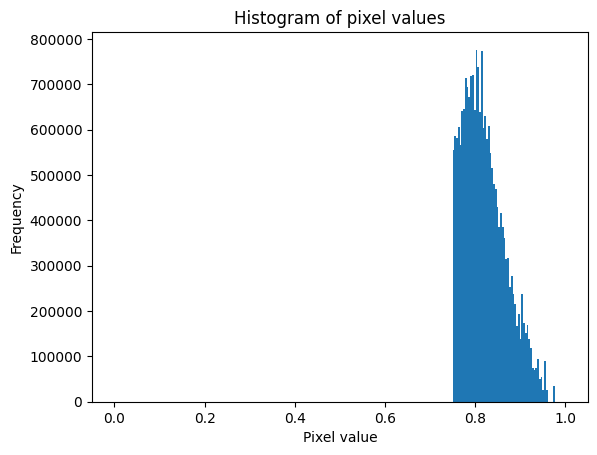

In [ ]:
import matplotlib.pyplot as plt

plt.hist(raster_image.ravel(), bins=256, range=[0, 1])
plt.title('Histogram of pixel values')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.show()


Mean pixel value: nan
Median pixel value: nan


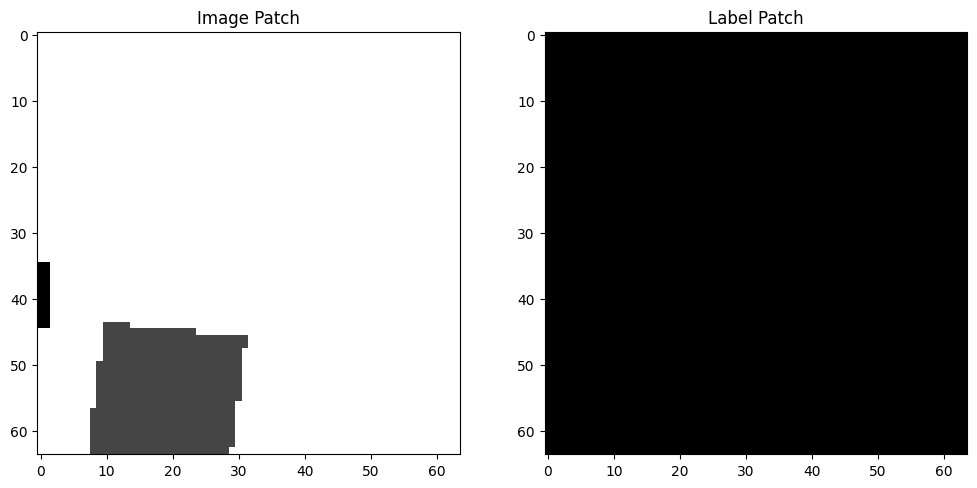

In [ ]:
# Calculate mean and median of the pixel values
mean_value = np.mean(raster_image)
median_value = np.median(raster_image)

print(f"Mean pixel value: {mean_value}")
print(f"Median pixel value: {median_value}")

# Choose a threshold around the mean or median
threshold = median_value  # or set threshold = 0.8 based on histogram inspection

# Function to create labels based on new threshold
def create_labels(image, threshold):
    labels = np.where(image >= threshold, 1, 0)
    return labels

labels = create_labels(raster_image, threshold=threshold)

# Check a few patches visually to ensure correctness
import matplotlib.pyplot as plt

# Plot a few patches to visually inspect
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(raster_image[0:64, 0:64], cmap='gray')
ax[0].set_title('Image Patch')
ax[1].imshow(labels[0:64, 0:64], cmap='gray')
ax[1].set_title('Label Patch')
plt.show()


Mean pixel value: 0.22135746479034424
Median pixel value: 0.0
Epoch 1/20
483/483 [==============================] - 658s 1s/step - loss: 0.0454 - accuracy: 0.9898 - val_loss: 0.0127 - val_accuracy: 0.9959 - lr: 0.0010
Epoch 2/20
483/483 [==============================] - 645s 1s/step - loss: 0.0226 - accuracy: 0.9937 - val_loss: 0.0206 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 3/20
483/483 [==============================] - 647s 1s/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.0130 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 4/20
483/483 [==============================] - 643s 1s/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.0117 - val_accuracy: 0.9946 - lr: 0.0010
Epoch 5/20
483/483 [==============================] - 629s 1s/step - loss: 0.0148 - accuracy: 0.9945 - val_loss: 0.0157 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 6/20
483/483 [==============================] - 648s 1s/step - loss: 0.0151 - accuracy: 0.9942 - val_loss: 0.0175 - val_accuracy: 0.9925 - lr: 0.0010
Ep

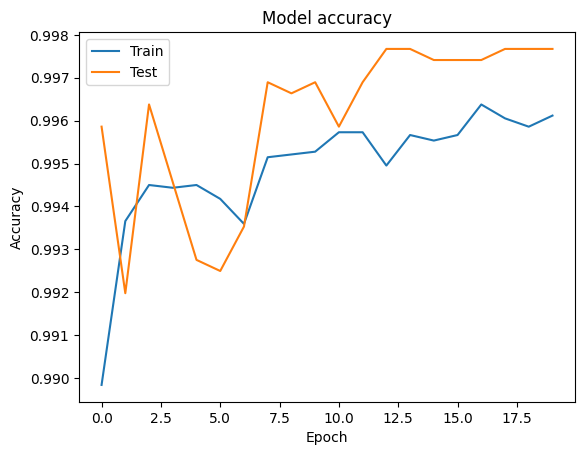

In [5]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Load TIFF image
def load_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read the first band
        return image

# Preprocess data
def preprocess_data(file_path, threshold=0.8, patch_size=64):
    raster_image = load_tiff_image(file_path)

    # Handle NaN and Inf values
    raster_image = np.nan_to_num(raster_image, nan=0.0, posinf=0.0, neginf=0.0)

    # Calculate mean and median pixel values
    mean_value = np.nanmean(raster_image)
    median_value = np.nanmedian(raster_image)
    print(f"Mean pixel value: {mean_value}")
    print(f"Median pixel value: {median_value}")

    # Normalize pixel values
    raster_image = (raster_image - mean_value) / (np.nanmax(raster_image) - mean_value)

    # Create labels based on threshold
    def create_labels(image, threshold):
        labels = np.where(image >= threshold, 1, 0)
        return labels

    labels = create_labels(raster_image, threshold)

    # Generate patches
    def generate_patches(image, labels, patch_size):
        image_patches = []
        label_patches = []
        num_patches_x = image.shape[1] // patch_size
        num_patches_y = image.shape[0] // patch_size

        for i in range(num_patches_y):
            for j in range(num_patches_x):
                img_patch = image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                lbl_patch = labels[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
                image_patches.append(img_patch)
                label_patches.append(lbl_patch)

        return np.array(image_patches), np.array(label_patches)

    X, Y = generate_patches(raster_image, labels, patch_size)

    # Split into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Flatten labels and one-hot encode
    Y_train_flat = np.where(Y_train.mean(axis=(1, 2)) >= threshold, 1, 0)
    Y_test_flat = np.where(Y_test.mean(axis=(1, 2)) >= threshold, 1, 0)

    num_classes = 2
    Y_train_one_hot = to_categorical(Y_train_flat, num_classes=num_classes)
    Y_test_one_hot = to_categorical(Y_test_flat, num_classes=num_classes)

    # Reshape images for model input
    X_train = X_train.reshape(-1, patch_size, patch_size, 1)
    X_test = X_test.reshape(-1, patch_size, patch_size, 1)

    return X_train, X_test, Y_train_one_hot, Y_test_one_hot

# Define ResNet50 architecture with Dropout
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters= F2, kernel_size= (f,f), strides=(1,1), padding='same', name = conv_name_base+'2b', kernel_initializer= glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name= bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size= (1,1), strides=(1,1), padding='valid', name = conv_name_base+ '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3 , name=bn_name_base + '2c')(X)

    # Adding shortcut value to main path and passing it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', padding='same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', padding='valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Adding shortcut value to main path and passing it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)

    return X

def ResNet50(input_shape = (64, 64, 1), classes = 2):
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')

    # Average Pooling
    X = AveragePooling2D(pool_size=(2,2))(X)

    # Flatten output
    X = Flatten()(X)

    # Add Dropout layer
    X = Dropout(0.5)(X)

    # Dense layer for classification
    X = Dense(classes, activation='softmax', kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# Prepare data
X_train, X_test, Y_train_one_hot, Y_test_one_hot = preprocess_data('/content/drive/MyDrive/building dataset delhi ncr/Delhi_NCR_Buildings_Raster_TIFF - Copy.tif')

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create model
model = ResNet50(input_shape=(64, 64, 1), classes=2)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    datagen.flow(X_train, Y_train_one_hot, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=20,
    validation_data=(X_test, Y_test_one_hot),
    callbacks=[reduce_lr, early_stop]
)

# Evaluate model
score = model.evaluate(X_test, Y_test_one_hot, verbose=0)
print(f"Test loss: {score[0]}")
print(f"Test accuracy: {score[1]}")

# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
